<a href="https://colab.research.google.com/github/madelezhia/vision-systems-lab/blob/main/II-SoTA/CLIP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP for Zero-Shot Classification

In [1]:
from google.colab import drive
drive.mount('/gdrive')



Mounted at /gdrive


## Importing CLIP from HuggingFace

In [2]:
from transformers import CLIPModel, CLIPProcessor
import torch
from PIL import Image
import requests


In [3]:
# CLIP
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
print(type(model))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [4]:
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
processor

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, spec

## CLIP as a zero-shot classifier

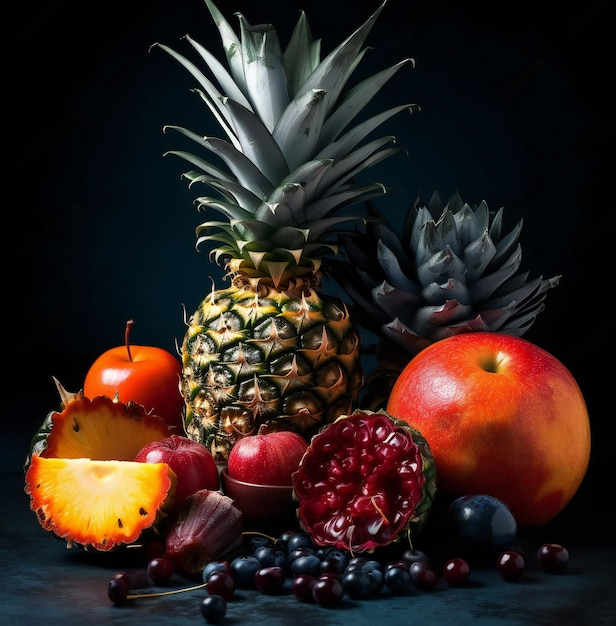

In [6]:
from PIL import Image

image_path = "/gdrive/MyDrive/Colab Notebooks/Portfolio/II-SoTA/pineapple-sits-table-with-other-fruits_726745-5475-3767101720.jpg"
image = Image.open(image_path).convert("RGB")

image

In [7]:
# Notice what happens with the output probabilities
# when we make the labels more specific
text = ['a bear',
        'a pen',
        'an apple',
        'a pineapple among other fruits',
        'a still life',
        'a table',
        'many fruits'
           ]

inputs = processor(text=text,
                   images=[image],
                   return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image

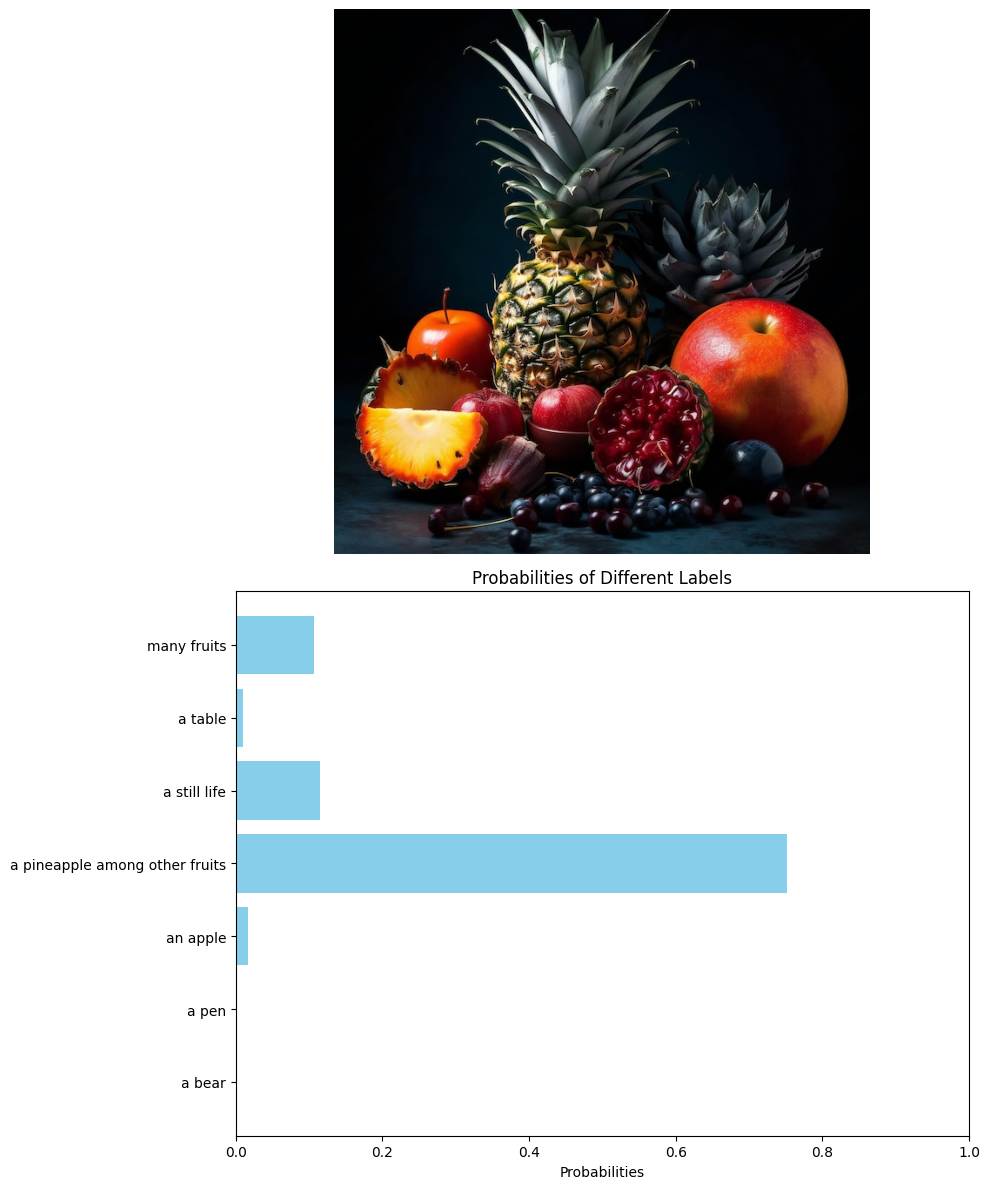

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# @title Probabilities at different temperatures {run:'auto'}

temperature = 1.7  # @param {type: "slider", min: 0.01, max: 2.0, step:0.01}

# Creating a subplot with an image in the first row and the histogram in the second row
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

axes[0].imshow(np.array(image))
axes[0].axis('off')  # Turning off the axis for the image

probs = (logits_per_image/temperature).softmax(dim=1)

# Creating the horizontal bar plot in the second subplot
axes[1].barh(text, probs.detach().numpy().flatten(), color='skyblue')
axes[1].set_xlim(0, 1)  # Setting the x-axis limit from 0 to 1

axes[1].set_xlabel('Probabilities')
axes[1].set_title('Probabilities of Different Labels')

plt.tight_layout()
plt.show()